In [2]:
import tensorflow as tf

(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [13]:
model.fit(X_train,y_train, epochs=20, 
          validation_data=(X_valid,y_valid))

Epoch 1/20
1719/1719 [==============================] - 10s 5ms/step - loss: 0.2293 - accuracy: 0.9345 - val_loss: 0.2026 - val_accuracy: 0.9440
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1979 - accuracy: 0.9434 - val_loss: 0.1831 - val_accuracy: 0.9498
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1745 - accuracy: 0.9496 - val_loss: 0.1629 - val_accuracy: 0.9570
Epoch 4/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1553 - accuracy: 0.9555 - val_loss: 0.1450 - val_accuracy: 0.9596
Epoch 5/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1397 - accuracy: 0.9605 - val_loss: 0.1348 - val_accuracy: 0.9640
Epoch 6/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1262 - accuracy: 0.9639 - val_loss: 0.1270 - val_accuracy: 0.9644
Epoch 7/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1156 - accuracy: 0.9671 - val_loss: 0.1200 - val_accuracy

In [21]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)


In [22]:
expo_lr = ExponentialLearningRate(factor=1.005)

In [23]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expo_lr])

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.5210 - val_loss: nan - val_accuracy: 0.0958
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 8/10
1719/1719 [===========

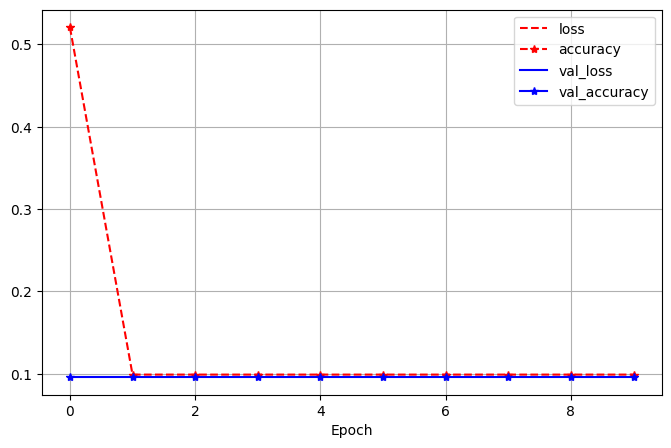

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5), grid=True, xlabel="Epoch",
style=["r--", "r--*", "b-", "b-*"])
plt.show()


In [34]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
    sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                    metrics=["accuracy"])
    
    return model

Using TensorFlow backend


In [36]:
random_search_tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=5, overwrite=True,
                                        directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                            validation_data=(X_valid, y_valid))



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
5                 |5                 |n_hidden
25                |25                |n_neurons
0.00065625        |0.00065625        |learning_rate
sgd               |sgd               |optimizer

Epoch 1/10
1264/1719 [=====================>........] - ETA: 1s - loss: 2.2913 - accuracy: 0.1451

KeyboardInterrupt: 

In [37]:
from pathlib import Path
from time import strftime

def log_dir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = log_dir()

early_stp = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint("my_mnist_model", save_best_only=True)
tensor_bd = tf.keras.callbacks.TensorBoard(run_logdir,profile_batch=(100,200))

model.fit(X_train, y_train, epochs=20,
          validation_data=(X_valid,y_valid),
          callbacks=[checkpoint, early_stp, tensor_bd])

Epoch 1/20
1719/1719 [==============================] - 11s 6ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 2/20
1719/1719 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 3/20
1719/1719 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 4/20
1719/1719 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 5/20
1719/1719 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 6/20
1719/1719 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 7/20
1719/1719 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958
Epoch 8/20
1719/1719 [=======